#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Callable

In [23]:
def min_max_norm(val: int, min_val: int, max_val: int, new_min: float, new_max: float) -> float:
    return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

In [24]:
class Chromosome:
    def __init__(self, length, array=None):
        if array is None:
            self._array = np.random.randint(0, 2, length)
        else:
            self._array = array
        self._length = length
    
    def decode(self, lower_bound: int, upper_bound: int, aoi: Tuple[float, float]) -> float:
        bit_number = upper_bound - lower_bound
        decimal_value = 0
        for i in range(bit_number):
            decimal_value += self._array[lower_bound + i].item() * pow(2, bit_number - i - 1)
        return min_max_norm(decimal_value, 0, pow(2, bit_number - 1), *aoi)
    
    def mutation(self, probability: float) -> None:
        if np.random.uniform(0, 1) < probability:
            index = np.random.randint(len(self._array))
            self._array[index] = int(not self._array[index])
    
    def crossover(self, other: 'Chromosome') -> Tuple['Chromosome', 'Chromosome']:
        assert self._length == other._length
        
        index = np.random.randint(self._length)
        child1 = Chromosome(self._length, np.concatenate((self._array[:index], other._array[index:])))
        child2 = Chromosome(self._length, np.concatenate((other._array[:index], self._array[index:])))
        return child1, child2

In [25]:
class GeneticAlgorithm:
    def __init__(self, chromosome_length: int, obj_func_num_args: int, objective_function,
                 aoi: Tuple[float, float], population_size=1000,
                 tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
        assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
        self._chromosome_lengths = chromosome_length
        self._obj_func_num_args = obj_func_num_args
        self._bits_per_arg = int(chromosome_length / obj_func_num_args)
        self._objective_function = objective_function
        self._aoi = aoi
        self._population_size = population_size
        self._tournament_size = tournament_size
        self._mutation_probability = mutation_probability
        self._crossover_probability = crossover_probability
        self._num_steps = num_steps
        
        self._population = [Chromosome(self._chromosome_lengths) for _ in range(self._population_size)]
        self._trace = []
    
    def get_objective_arguments(self, chromosome: Chromosome) -> List[float]:
        arguments = []
        for i in range(self._obj_func_num_args):
            arguments.append(chromosome.decode(self._bits_per_arg * i, self._bits_per_arg * (i + 1), self._aoi))
        return arguments
    
    def eval_objective_func(self, chromosome: Chromosome) -> float:
        return self._objective_function(*self.get_objective_arguments(chromosome))
  
    def tournament_reproduction(self) -> List[Chromosome]:
        temporary_generation = []
        for _ in range(self._population_size):
            tournament_members = np.random.choice(self._population, self._tournament_size)
            temporary_generation.append(min(tournament_members, key=self.eval_objective_func))
        return temporary_generation
    
    def crossover_and_mutate(self, population: List[Chromosome]) -> List[Chromosome]:
        new_generation = []
        
        for i in range(0, self._population_size, 2):
            parent1 = population[i]
            parent2 = population[i + 1]
            
            if np.random.uniform(0, 1) < self._crossover_probability:
                child1, child2 = parent1.crossover(parent2)
                new_generation.extend([child1, child2])
            else:
                new_generation.extend([parent1, parent2])
        
        for chromosome in new_generation:
            chromosome.mutation(self._mutation_probability)
        
        return new_generation
    
    def find_best(self, population: List[Chromosome]) -> Tuple[Chromosome, float]:
        best_chromosome = min(population, key=self.eval_objective_func)
        best_value = self.eval_objective_func(best_chromosome)
        return best_chromosome, best_value
    
    def plot_func(self, trace):
        X = np.arange(-2, 3, 0.05)
        Y = np.arange(-4, 2, 0.05)
        X, Y = np.meshgrid(X, Y)
        Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
        plt.figure()
        plt.contour(X, Y, Z, 10)
        
        argument_x = [entry["Arguments"][0] for entry in trace]
        argument_y = [entry["Arguments"][1] for entry in trace]
        
        cmaps = [[i / len(trace), 0, 0] for i in range(len(trace))]
        plt.scatter(argument_x, argument_y, c=cmaps)
        plt.show()
  
    def run(self, plot=False, verbose=False) -> Tuple[Chromosome, List[float], float]:
        best_chromosome, best_value = self.find_best(self._population)
        best_arguments = self.get_objective_arguments(best_chromosome)
        self._trace.append({"Arguments": best_arguments, "Value": best_value})
        
        if verbose:
            print(f"Initial best individual parameters:\t Arguments: {best_arguments}\t Value: {best_value: .3e}\t")
        
        for i in range(self._num_steps):
            temporary_population = self.tournament_reproduction()
            mutants = self.crossover_and_mutate(temporary_population)
            
            step_best_chromosome, step_best_value = self.find_best(mutants)
            step_best_arguments = self.get_objective_arguments(step_best_chromosome)
            self._trace.append({"Arguments": step_best_arguments, "Value": step_best_value})
            
            if verbose:
                print(f"Iteration: {i + 1}\t Arguments: {step_best_arguments}\t Value: {step_best_value: .3e}\t")
            
            if step_best_value <= best_value:
                best_chromosome = step_best_chromosome
                best_arguments = step_best_arguments
                best_value = step_best_value
            
            self._population = mutants
        
        if plot:
            self.plot_func(self._trace)
        
        return best_chromosome, best_arguments, best_value
        

## Testy algorytmu
### Zadana funkcja do wyznaczenia jej minimum

In [26]:
def f(x: float, y: float) -> float:
    return  1.5 - np.exp(-x**2 - y**2) - 0.5*np.exp(-(x - 1)**2 - (y + 2)**2)

### Eksperyment 1
Pierwszy eksperyment wykonano dla chromosomu o długości 32b (po 16b na zmienną), wielkością populacji 1000 oraz ilością iteracji 10:

Initial best individual parameters:	 Arguments: [-0.3631591796875, 0.2545166015625]	 Value:  6.780e-01	
Iteration: 1	 Arguments: [-0.2899169921875, -0.00091552734375]	 Value:  5.789e-01	
Iteration: 2	 Arguments: [-0.18157958984375, 0.24017333984375]	 Value:  5.858e-01	
Iteration: 3	 Arguments: [-0.09307861328125, -0.05889892578125]	 Value:  5.086e-01	
Iteration: 4	 Arguments: [-0.16510009765625, -0.26947021484375]	 Value:  5.886e-01	
Iteration: 5	 Arguments: [0.02044677734375, 0.2215576171875]	 Value:  5.469e-01	
Iteration: 6	 Arguments: [0.047607421875, -0.15838623046875]	 Value:  5.202e-01	
Iteration: 7	 Arguments: [0.10955810546875, 0.0634765625]	 Value:  5.127e-01	
Iteration: 8	 Arguments: [0.04302978515625, -0.12725830078125]	 Value:  5.119e-01	
Iteration: 9	 Arguments: [0.0225830078125, -0.00396728515625]	 Value:  4.969e-01	
Iteration: 10	 Arguments: [0.0225830078125, -0.00396728515625]	 Value:  4.969e-01	


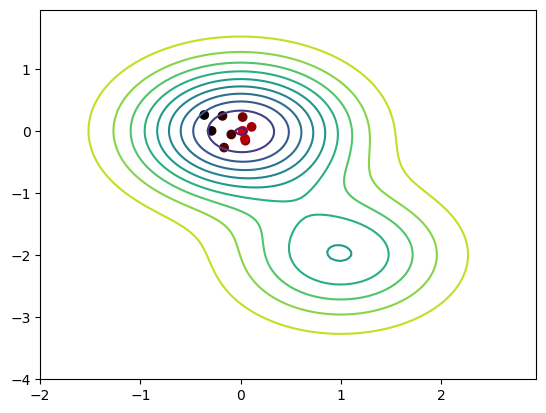

In [27]:
genetic_algorithm = GeneticAlgorithm(32, 2, f, (-5.0, 5.0), population_size=1000, num_steps=10)
best_chromosome, best_arguments, best_value = genetic_algorithm.run(plot=True, verbose=True)

In [28]:
print(f"Real minimum at: (0, 0); \tf(0, 0) = {f(0.0, 0.0)}; \tFound minimum: {best_arguments}; \tValue at found minimum: f(x1, x2) = {best_value}; \tError: {abs(best_value - f(0.0, 0.0))}")

Real minimum at: (0, 0); 	f(0, 0) = 0.49663102650045726; 	Found minimum: [0.0225830078125, -0.00396728515625]; 	Value at found minimum: f(x1, x2) = 0.49694647140590686; 	Error: 0.00031544490544960224


Pierwsza różnica względem metody gradientowej jest widoczna od razu po odpaleniu algorytmu - jest on o wiele wolniejszy. W tym przypadku 10 iteracji wykonywało się około 21 sekund. Jak widać, algorytm zbliża się do rozwiązania, ale nadal błąd jest dość duży.
### Eksperyment 2
Spróbowano zwiększyć ilość iteracji do 100, aby zmniejszyć błąd:


Initial best individual parameters:	 Arguments: [-0.13214111328125, 0.18157958984375]	 Value:  5.480e-01	
Iteration: 1	 Arguments: [0.0445556640625, -0.0750732421875]	 Value:  5.027e-01	
Iteration: 2	 Arguments: [0.0445556640625, -0.07476806640625]	 Value:  5.026e-01	
Iteration: 3	 Arguments: [0.0445556640625, -0.07476806640625]	 Value:  5.026e-01	
Iteration: 4	 Arguments: [0.0445556640625, -0.07476806640625]	 Value:  5.026e-01	
Iteration: 5	 Arguments: [0.0445556640625, -0.07476806640625]	 Value:  5.026e-01	
Iteration: 6	 Arguments: [0.03997802734375, 0.0445556640625]	 Value:  5.005e-01	
Iteration: 7	 Arguments: [0.03997802734375, 0.0445556640625]	 Value:  5.005e-01	
Iteration: 8	 Arguments: [-0.0299072265625, -0.00152587890625]	 Value:  4.977e-01	
Iteration: 9	 Arguments: [-0.0299072265625, -0.0054931640625]	 Value:  4.977e-01	
Iteration: 10	 Arguments: [0.04547119140625, -0.00244140625]	 Value:  4.984e-01	
Iteration: 11	 Arguments: [-0.013427734375, -0.0103759765625]	 Value:  4.969e

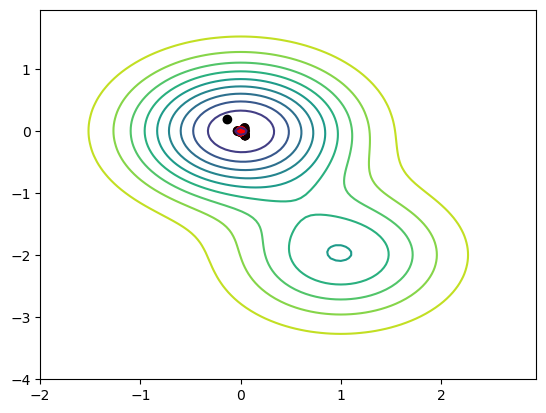

In [31]:
genetic_algorithm = GeneticAlgorithm(32, 2, f, (-5.0, 5.0), population_size=1000, num_steps=100)
best_chromosome, best_arguments, best_value = genetic_algorithm.run(plot=True, verbose=True)

In [32]:
print(f"Real minimum at: (0, 0); \tf(0, 0) = {f(0.0, 0.0)}; \tFound minimum: {best_arguments}; \tValue at found minimum: f(x1, x2) = {best_value}; \tError: {abs(best_value - f(0.0, 0.0))}")

Real minimum at: (0, 0); 	f(0, 0) = 0.49663102650045726; 	Found minimum: [0.00335693359375, -0.00701904296875]; 	Value at found minimum: f(x1, x2) = 0.49657250240993955; 	Error: 5.852409051770868e-05


Tym razem osiągnięto już trochę lepszą dokładność, ale kosztem czasu obliczeń, który wyniósł aż 3,5 minuty.
### Eksperyment 3
Aby przyspieszyć działanie algorytmu zmniejszono wielkość populacji do 100:

Initial best individual parameters:	 Arguments: [2.23602294921875, -0.9857177734375]	 Value:  1.459e+00	
Iteration: 1	 Arguments: [0.216064453125, -0.069580078125]	 Value:  5.437e-01	
Iteration: 2	 Arguments: [-0.34515380859375, -0.56732177734375]	 Value:  8.461e-01	
Iteration: 3	 Arguments: [-0.34515380859375, -0.0238037109375]	 Value:  6.112e-01	
Iteration: 4	 Arguments: [-0.34515380859375, -0.0238037109375]	 Value:  6.112e-01	
Iteration: 5	 Arguments: [0.27984619140625, -0.02410888671875]	 Value:  5.699e-01	
Iteration: 6	 Arguments: [0.3192138671875, -0.0238037109375]	 Value:  5.911e-01	
Iteration: 7	 Arguments: [0.3192138671875, -0.0238037109375]	 Value:  5.911e-01	
Iteration: 8	 Arguments: [0.2215576171875, -0.0457763671875]	 Value:  5.439e-01	
Iteration: 9	 Arguments: [-0.03265380859375, -0.0238037109375]	 Value:  4.982e-01	
Iteration: 10	 Arguments: [-0.01800537109375, -0.0244140625]	 Value:  4.973e-01	
Iteration: 11	 Arguments: [-0.01800537109375, -0.0244140625]	 Value:  4.973e

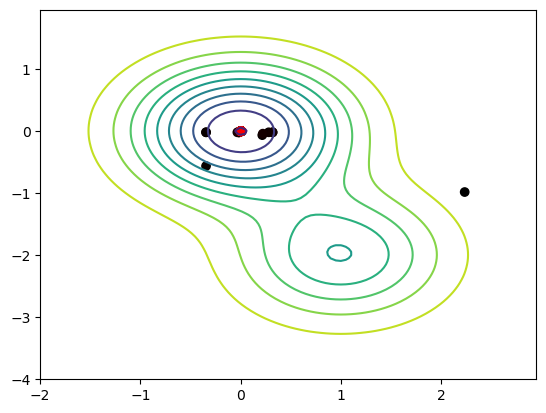

In [33]:
genetic_algorithm = GeneticAlgorithm(32, 2, f, (-5.0, 5.0), population_size=100, num_steps=100)
best_chromosome, best_arguments, best_value = genetic_algorithm.run(plot=True, verbose=True)

In [34]:
print(f"Real minimum at: (0, 0); \tf(0, 0) = {f(0.0, 0.0)}; \tFound minimum: {best_arguments}; \tValue at found minimum: f(x1, x2) = {best_value}; \tError: {abs(best_value - f(0.0, 0.0))}")

Real minimum at: (0, 0); 	f(0, 0) = 0.49663102650045726; 	Found minimum: [0.00335693359375, -0.0067138671875]; 	Value at found minimum: f(x1, x2) = 0.49657255235639675; 	Error: 5.847414406051632e-05


Zmniejszenie wielkości populacji 10-krotnie spowodowało w tym przypadku skórcenie działania algorytmu około 50 razy. Uzyskano podobny błąd jak poprzednio, a algorytm zbiegł do otoczenia minimum w podobnej ilości iteracji co w poprzednich przypadkach.
### Eksperyment 4
Tym razem zwiększono ilość iteracji do 1000 przy wielkości populacji 100:

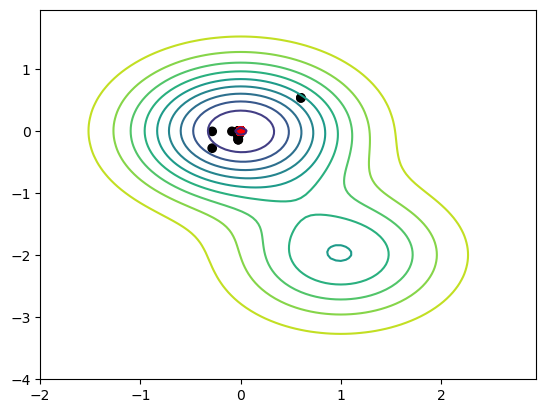

In [39]:
genetic_algorithm = GeneticAlgorithm(32, 2, f, (-5.0, 5.0), population_size=100, num_steps=1000)
best_chromosome, best_arguments, best_value = genetic_algorithm.run(plot=True, verbose=False)

In [41]:
print(f"Real minimum at: (0, 0); \tf(0, 0) = {f(0.0, 0.0)}; \tFound minimum: {best_arguments}; \tValue at found minimum: f(x1, x2) = {best_value}; \tError: {abs(best_value - f(0.0, 0.0))}")

Real minimum at: (0, 0); 	f(0, 0) = 0.49663102650045726; 	Found minimum: [-0.00030517578125, -0.0048828125]; 	Value at found minimum: f(x1, x2) = 0.4965906925059815; 	Error: 4.033399447578301e-05


Jak widać, wzrost ilości iteracji w zasadzie nie przyniósł pomniejszenia błędu.
### Eksperyment 5
Tym razem zmniejszono jeszcze bardziej wielkość populacji przy tej samej liczbie iteracji równej 1000:


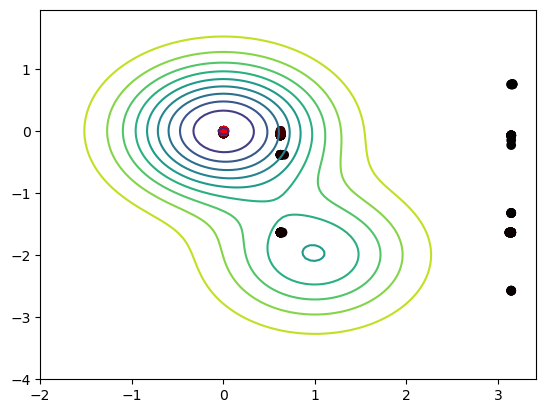

In [42]:
genetic_algorithm = GeneticAlgorithm(32, 2, f, (-5.0, 5.0), population_size=10, num_steps=1000)
best_chromosome, best_arguments, best_value = genetic_algorithm.run(plot=True, verbose=False)

In [43]:
print(f"Real minimum at: (0, 0); \tf(0, 0) = {f(0.0, 0.0)}; \tFound minimum: {best_arguments}; \tValue at found minimum: f(x1, x2) = {best_value}; \tError: {abs(best_value - f(0.0, 0.0))}")

Real minimum at: (0, 0); 	f(0, 0) = 0.49663102650045726; 	Found minimum: [0.0048828125, -0.00518798828125]; 	Value at found minimum: f(x1, x2) = 0.49657756079269033; 	Error: 5.346570776693094e-05


Jak widać, otrzymano błąd tego samego rzędu, ale mniejszym kosztem obliczeń.
### Eksperyment 6
Spróbowano jeszcze bardziej zwiększyć liczbę iteracji:

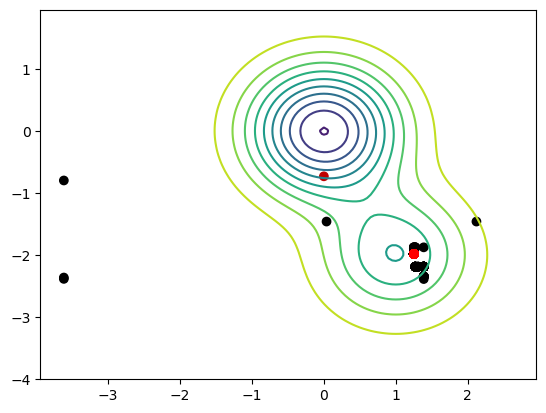

In [44]:
genetic_algorithm = GeneticAlgorithm(32, 2, f, (-5.0, 5.0), population_size=10, num_steps=10000)
best_chromosome, best_arguments, best_value = genetic_algorithm.run(plot=True, verbose=False)

In [45]:
print(f"Real minimum at: (0, 0); \tf(0, 0) = {f(0.0, 0.0)}; \tFound minimum: {best_arguments}; \tValue at found minimum: f(x1, x2) = {best_value}; \tError: {abs(best_value - f(0.0, 0.0))}")

Real minimum at: (0, 0); 	f(0, 0) = 0.49663102650045726; 	Found minimum: [0.0, -0.732421875]; 	Value at found minimum: f(x1, x2) = 0.8782877199518074; 	Error: 0.38165669345135017


Niestety rezultat był wręcz przeciwny, algorytm nie był w stanie zbiec do minimum globalnego, a zatrzymał się w okolicy minimum lokalnego.
### Eksperyment 6


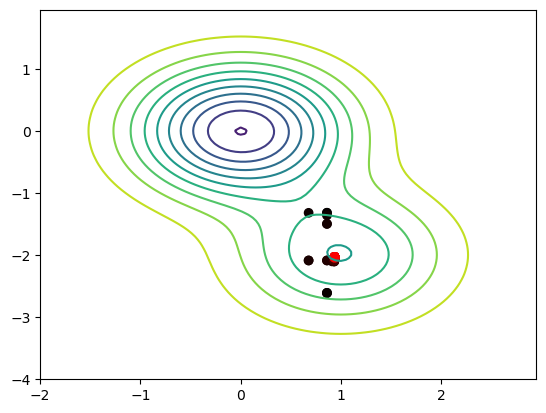

In [59]:
genetic_algorithm = GeneticAlgorithm(64, 2, f, (-5.0, 5.0), population_size=100, num_steps=100)
best_chromosome, best_arguments, best_value = genetic_algorithm.run(plot=True, verbose=False)

In [60]:
print(f"Real minimum at: (0, 0); \tf(0, 0) = {f(1.0, -2.0)}; \tFound minimum: {best_arguments}; \tValue at found minimum: f(x1, x2) = {best_value}; \tError: {abs(best_value - f(1.0, -2.0))}")

Real minimum at: (0, 0); 	f(0, 0) = 0.9932620530009146; 	Found minimum: [0.9374999906867743, -2.031254773028195]; 	Value at found minimum: f(x1, x2) = 0.99573060733394; 	Error: 0.0024685543330253967


W tym przypadku zwiększenie długości chromosomu nie pomogło.
## Wnioski
Patrząc na powyższe wykresy można stwierdzić, że metoda ta za każdym razem startuje z innych punktów początkowych i kończy swe działanie w innych punktach. To jest główna różnica algorytmów ewolucyjnych w stosunku do metody gradientowej lub Newtona - są one niedeterministyczne, za każdym kolejnym wywołaniem zwracają one trochę inne wyniki. Jest to oczywiste, wszakże na wielu etapach tej metody używa się zmiennych losowych. Warto też podkreślić to, że metoda gradientu prostego dawała rozwiązanie w ekstremum, w kierunku którego funkcja zbiegała najszybciej. Algorytmy ewolucyjne są w stanie znajdować ekstrema lokalne i globalne, ale nigdy nie wiadomo, które zostanie odnalezione w danej iteracji. 

Z eksperymentów wynika także to, że duża populacja nie zawsze pomaga. Dzięki niej algorytm szybko zbiega do otoczenia rozwiązania, ale potem nie da rady jego osiągnąć, co wynika z faktu, że dla dużej populacji większa ilość elementów wektora chromosomów ulega zmianie - łatwiej znajdować nowe w miarę dobre rozwiązania, ale trudno jest wyznaczyć je precyzyjnie. Z kolei mała populacja sprawia, że na początku algorytm zbiega wolniej, ale potem zaczyna działać lepiej. Z kolei zbyt duże zwiększenie ilości iteracji nie zawsze może służyć, o czym przekonano się podczas eksperymentów. Czasami zbyt duża ilość iteracji sprawia, że w wyniku jakiegoś zaburzenia algorytm zaczyna się delikatnie rozbiegać. 